# Instability of logistic regression for well-separated classes

## 1. Context:

I was performing logistic regression on a dataset - response was credit default status (yes/no) for given credit balance (varying from 0-20000). The training sets were being generated (simulated) via a governing logistic function itself. It was noticed that for the same parameters, the fit scores for the training sets generated in different attempts were varying between 50% and 87%. This was the source of the investigation - when is logistic regression unstable.

## 2. Aim:

We will try to understand why instability in fit scores for training sets generated from the same simulation function occur. A hint for this was found in <b><i>Introduction to Statistical Learning - James, Witten, Hastie, Tibshirani</i></b> section 4.4, page 138 -
<blockquote>When the classes are well-separated, the parameter estimates for the logistic regression model are surprisingly unstable. Linear discriminant analysis does not suffer from this problem.</blockquote>

We will try to visualize this instability via empirical studies and then see if linear discriminant analysis, as claimed above, solves the problem. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import gc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# Training set generating function
def generateTrainingSet(n, defaultProportion, defaultProbabilityDist, xDist, *args, **kwargs):
    trainingSet = pd.DataFrame(columns=['Balance','Default'])
    defaultSize = np.around(n*defaultProportion)
    while len(trainingSet.loc[trainingSet['Default']==0.0]) < n-defaultSize:
        x = xDist(*args, **kwargs)
        p = defaultProbabilityDist(x)
        y = np.random.choice([0,1],p=[(1-p),p])
        if y==0:
            trainingSet.loc[len(trainingSet)] = [x,y]
        if (y==1) and (len(trainingSet.loc[trainingSet['Default']==1.0]) < defaultSize):
            trainingSet.loc[len(trainingSet)] = [x,y]

    while len(trainingSet) < n:
        x = x = xDist(*args, **kwargs)
        p = defaultProbabilityDist(x)
        y = np.random.choice([0,1],p=[(1-p),p])
        if y==1:
            trainingSet.loc[len(trainingSet)] = [x,y]
            
    return trainingSet

## 3. Simulation model

Below is the probability distribution curve used to generate the training set and the training set itself.

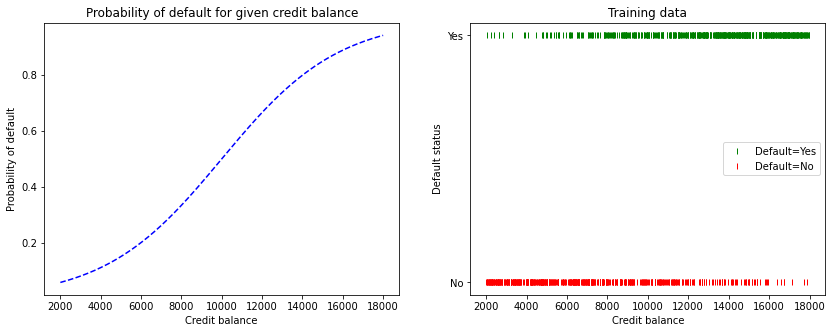

In [3]:
high,low = 18000,2000
gap = high-low
A = np.array([[1,high-gap/10],[1,low+gap/10]])
C = np.array([[np.log(9)],[np.log(1/9)]])
B = np.linalg.solve(A,C)
defaultProbabilityDist = lambda x: np.exp(B[0,0]+B[1,0]*x)/(1+np.exp(B[0,0]+B[1,0]*x))
trainingSet = generateTrainingSet(1000,0.5,defaultProbabilityDist,np.random.uniform,low=low,high=high)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

X = np.linspace(low, high, 500)
Y = [defaultProbabilityDist(x) for x in X]
ax1.plot(X,Y,'--b')
ax1.set_xlabel('Credit balance')
ax1.set_ylabel('Probability of default')
ax1.set_title('Probability of default for given credit balance')

ax2.plot(trainingSet.loc[trainingSet['Default']==1.0]['Balance'], trainingSet.loc[trainingSet['Default']==1.0]['Default'], '|g', label='Default=Yes')
ax2.plot(trainingSet.loc[trainingSet['Default']==0.0]['Balance'], trainingSet.loc[trainingSet['Default']==0.0]['Default'], '|r',label='Default=No')
ax2.set_xlabel('Credit balance')
ax2.set_ylabel('Default status')
ax2.set_yticks(ticks=[0.0,1.0])
ax2.set_yticklabels(['No','Yes'])
ax2.set_title('Training data')
ax2.legend();

Below, the separation of the two response classes (default=yes and default=no) in terms of the feature (credit balance) is displayed.

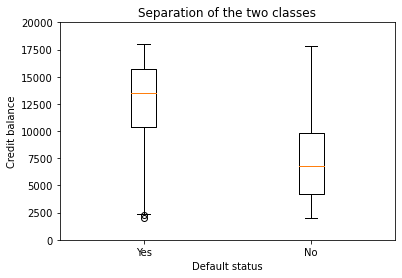

In [4]:
plt.boxplot([trainingSet.loc[trainingSet['Default']==1.0]['Balance'], trainingSet.loc[trainingSet['Default']==0.0]['Balance']],
           labels=['Yes','No'])
plt.xlabel('Default status')
plt.ylabel('Credit balance')
plt.ylim(0,20000)
plt.title('Separation of the two classes');

## 4. Instability vs class separation:

We prepare three training sets as above, with decreasing class separation. The decreasing class separations are displayed below.

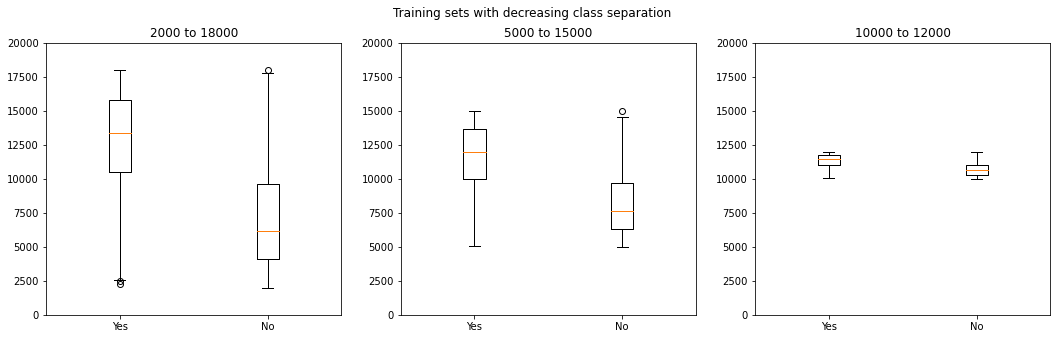

In [5]:
lows = np.array([2000,5000,10000])
highs = np.array([18000,15000,12000])
gaps = highs-lows
fig, axes = plt.subplots(1,3,figsize=(18,5))

for k,low,high,gap in zip(list(range(len(lows))),lows,highs,gaps):
    A = np.array([[1,high-gap/10],[1,low+gap/10]])
    C = np.array([[np.log(9)],[np.log(1/9)]])
    B = np.linalg.solve(A,C)
    defaultProbabilityDist = lambda x: np.exp(B[0,0]+B[1,0]*x)/(1+np.exp(B[0,0]+B[1,0]*x))
    trainingSet = generateTrainingSet(1000,0.5,defaultProbabilityDist,np.random.uniform,low=low,high=high)
    axes[k].boxplot([trainingSet.loc[trainingSet['Default']==1.0]['Balance'], trainingSet.loc[trainingSet['Default']==0.0]['Balance']],
           labels=['Yes','No'])
    #axes[k].set_xlabel('Default status')
    #axes[k].set_ylabel('Credit balance')
    axes[k].set_ylim(0,20000)
    title = f'{low} to {high}'
    axes[k].set_title(title)

fig.suptitle('Training sets with decreasing class separation');

For each of the above three class separation levels - 
<ul>
    <li>we generate 20 training sets</li>
    <li>apply logistic regression on each and find the fit scores</li>
    <li>thus, we have 20 fit scores for each level of class separation. The instability of the fit scores with changing class separation level is what interests us.</li>
</ul>

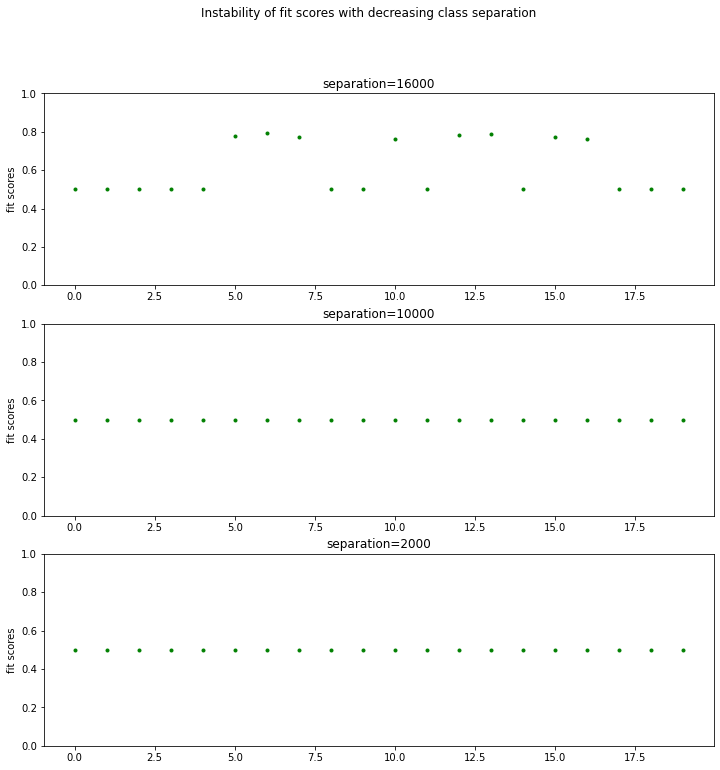

In [12]:
lows = np.array([2000,5000,10000])
highs = np.array([18000,15000,12000])
gaps = highs-lows
fig, axes = plt.subplots(3,1,figsize=(12,12),sharey='col')
axes[0].set_ylim(0,1)

for k,low,high,gap in zip(list(range(len(lows))),lows,highs,gaps):
    A = np.array([[1,high-gap/10],[1,low+gap/10]])
    C = np.array([[np.log(9)],[np.log(1/9)]])
    B = np.linalg.solve(A,C)
    defaultProbabilityDist = lambda x: np.exp(B[0,0]+B[1,0]*x)/(1+np.exp(B[0,0]+B[1,0]*x))
    scores=[]
    for i in range(20):
        trainingSet = generateTrainingSet(1000,0.5,defaultProbabilityDist,np.random.uniform,low=low,high=high)
        clf = LogisticRegression().fit(trainingSet[['Balance']],trainingSet['Default'])
        scores.append(clf.score(trainingSet[['Balance']],trainingSet['Default']))
        # print(low,i)
        del trainingSet
        del clf
        gc.collect()
    axes[k].plot(list(range(len(scores))),scores,'.g')
    axes[k].set_ylabel('fit scores')
    title=f'separation={gap}'
    axes[k].set_title(title)
    
fig.suptitle('Instability of fit scores with decreasing class separation')
fig.savefig(r'C:\Users\bubai\ISLRLearning\LabWork\Statistical Learning - Confusion to Clarity\Blog requirements\Instability of logistic regression for largely separated classes\SeparationVSInstability');

The separation values in the above plots is obtained thus -
<ul>
    <li>there is a credit balance, $x_{high}$ for which the probability of default=yes is 0.9, as per the governing probability distribution function</li>
    <li>similarly there is an $x_{low}$ for which the probability of default=yes is 0.1</li>
    <li>$x_{high}-x_{low}$ is the separation value, which is a good metric to represent the separation of the classes</li>
</ul>

From the above three plots it becomes clear how the instability of the fit scores decrease as class separation decreases. However a test on just 3 separation values is not robust enough. We need to run the test over many more separation levels to verify if variability of the fit scores indeed comes down with the separation values decreasing. Towards that end, we need one metric to capture the instability of the fit scores, given a separation value. The variance of the 20 fit scores for any given separation value will serve as a measure of the instability. We will study this variance against the separation value.

In [7]:
# We are not running this code block again as its result has already been captured once in a file - 
# C:\Users\bubai\ISLRLearning\LabWork\Statistical Learning - Confusion to Clarity\SeparationVsFitScoreVariability.xlsx. 
# The code block takes around 30 minutes to run.
'''
lows = np.concatenate((np.linspace(0,9950,20),np.linspace(9950,9995,20)))
highs = np.concatenate((np.linspace(20000,10050,20),np.linspace(10050,10005,20)))
gaps=highs-lows
scoreTable = pd.DataFrame(columns=np.around(gaps,2))
for k,low,high,gap in zip(list(range(len(lows))),lows, highs,gaps):
    A = np.array([[1,high-gap/10],[1,low+gap/10]])
    C = np.array([[np.log(9)],[np.log(1/9)]])
    B = np.linalg.solve(A,C)
    defaultProbabilityDist = lambda x: np.exp(B[0,0]+B[1,0]*x)/(1+np.exp(B[0,0]+B[1,0]*x))
    scores = []
    for i in range(20):
        trainingSet = generateTrainingSet(1000,0.5,defaultProbabilityDist,np.random.uniform,low=low,high=high)
        clf = LogisticRegression().fit(trainingSet[['Balance']],trainingSet['Default'])
        scores.append(clf.score(trainingSet[['Balance']],trainingSet['Default']))
        print(k,i,end='|')
        del trainingSet
        del clf
        gc.collect()
    scoreTable[np.around(gap,2)] = scores
'''
scoreTable = pd.read_excel('SeparationVsFitScoreVariability.xlsx',index_col=0)
scoreTable

,20000.00,18952.63,17905.26,16857.89,15810.53,14763.16,13715.79,12668.42,11621.05,10573.68,...,52.63,47.89,43.16,38.42,33.68,28.95,24.21,19.47,14.74,10.00
0,0.777,0.770,0.753,0.774,0.500,0.764,0.764,0.779,0.773,0.500,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,0.765,0.500,0.767,0.771,0.753,0.500,0.757,0.753,0.773,0.788,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0.762,0.500,0.774,0.775,0.791,0.500,0.500,0.777,0.778,0.500,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,0.775,0.500,0.500,0.500,0.776,0.500,0.784,0.764,0.785,0.790,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,0.760,0.500,0.784,0.761,0.753,0.785,0.745,0.769,0.778,0.500,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
5,0.500,0.500,0.500,0.780,0.737,0.773,0.750,0.781,0.758,0.500,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
6,0.500,0.500,0.757,0.500,0.500,0.778,0.500,0.500,0.500,0.500,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
7,0.500,0.500,0.775,0.780,0.784,0.774,0.788,0.754,0.787,0.500,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
8,0.500,0.766,0.756,0.782,0.500,0.789,0.763,0.757,0.500,0.500,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
9,0.500,0.772,0.764,0.781,0.500,0.500,0.500,0.778,0.500,0.500,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


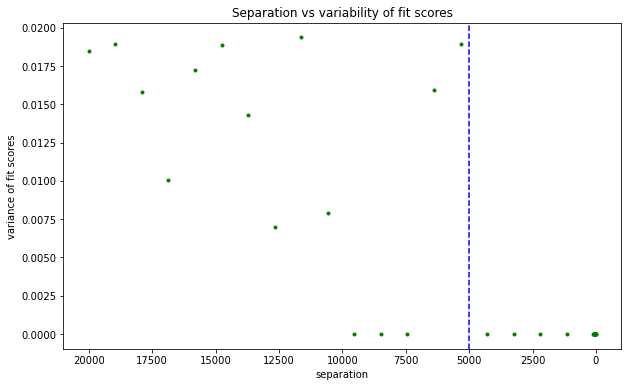

In [8]:
plt.figure(figsize=(10,6))
plt.plot(list(scoreTable.columns),list(scoreTable.var(axis=0)),'.g')
plt.xlabel('separation')
plt.ylabel('variance of fit scores')
plt.xlim(21000,-1000)
plt.axvline(5000,ls='--',c='b')
plt.title('Separation vs variability of fit scores');

The above plot shows that below a separation value of 5000 (the blue vertical line), variance vanishes altogether (note that the x-axis increases towards left). **True, that the fit scores are very poor in the end - 50%. But they are 'consistently' poor and that is what we are concerned with right now.** Also note that, as the separation was lowered the scale of the x-values remained the same - $O(10^3)$. Hence it seems that it is not the scale of feature values, rather the separation that causes the instability in the fit scores.

## 5. Remedy - linear discriminant analysis:

Linear discriminant analysis was suggested as the solution for this problem in the 'context' of this piece. So we will now see whether or not LDA suffers from this instability.

In [9]:
# We are not running this code block again as its result has already been captured once in a file - 
# C:\Users\bubai\ISLRLearning\LabWork\Statistical Learning - Confusion to Clarity\SeparationVsFitScoreVariabilityLDA.xlsx.
# One column with separation value 100 was repeated which had to be dropped from the excel file.
# The code block takes around 30 minutes to run.
'''
lows = np.concatenate((np.linspace(0,9950,20),np.linspace(9950,9995,20)))
highs = np.concatenate((np.linspace(20000,10050,20),np.linspace(10050,10005,20)))
gaps=highs-lows
scoreTableLDA = pd.DataFrame(columns=np.around(gaps,2))
for k,low,high,gap in zip(list(range(len(lows))),lows, highs,gaps):
    A = np.array([[1,high-gap/10],[1,low+gap/10]])
    C = np.array([[np.log(9)],[np.log(1/9)]])
    B = np.linalg.solve(A,C)
    defaultProbabilityDist = lambda x: np.exp(B[0,0]+B[1,0]*x)/(1+np.exp(B[0,0]+B[1,0]*x))
    scores = []
    for i in range(20):
        trainingSet = generateTrainingSet(1000,0.5,defaultProbabilityDist,np.random.uniform,low=low,high=high)
        lda = LinearDiscriminantAnalysis().fit(trainingSet[['Balance']],trainingSet['Default'])
        scores.append(lda.score(trainingSet[['Balance']],trainingSet['Default']))
        print(k,i,end='|')
        del trainingSet
        del lda
        gc.collect()
    scoreTableLDA[np.around(gap,2)] = scores
scoreTableLDA.to_excel('SeparationVsFitScoreVariabilityLDA.xlsx')
'''

scoreTableLDA = pd.read_excel('SeparationVsFitScoreVariabilityLDA.xlsx',index_col=0)
scoreTableLDA

,20000.00,18952.63,17905.26,16857.89,15810.53,14763.16,13715.79,12668.42,11621.05,10573.68,...,52.63,47.89,43.16,38.42,33.68,28.95,24.21,19.47,14.74,10.00
0,0.744,0.775,0.780,0.768,0.782,0.766,0.748,0.780,0.738,0.778,...,0.767,0.804,0.767,0.783,0.757,0.765,0.757,0.760,0.762,0.758
1,0.759,0.755,0.787,0.791,0.764,0.789,0.766,0.789,0.762,0.773,...,0.780,0.783,0.758,0.768,0.788,0.772,0.776,0.767,0.762,0.783
2,0.769,0.759,0.777,0.774,0.776,0.794,0.768,0.756,0.770,0.751,...,0.778,0.774,0.774,0.783,0.781,0.769,0.774,0.744,0.765,0.754
3,0.772,0.763,0.791,0.753,0.764,0.776,0.780,0.783,0.761,0.766,...,0.784,0.763,0.775,0.787,0.780,0.764,0.766,0.762,0.773,0.761
4,0.760,0.784,0.806,0.761,0.743,0.779,0.780,0.775,0.764,0.757,...,0.788,0.772,0.772,0.754,0.776,0.758,0.772,0.764,0.754,0.768
5,0.772,0.780,0.761,0.769,0.759,0.788,0.782,0.739,0.772,0.775,...,0.795,0.792,0.770,0.775,0.760,0.756,0.750,0.777,0.788,0.748
6,0.792,0.777,0.758,0.760,0.772,0.776,0.745,0.771,0.768,0.767,...,0.752,0.773,0.776,0.792,0.769,0.757,0.748,0.776,0.745,0.797
7,0.748,0.752,0.772,0.746,0.782,0.772,0.777,0.757,0.748,0.773,...,0.773,0.787,0.743,0.747,0.767,0.768,0.758,0.768,0.763,0.785
8,0.779,0.791,0.756,0.772,0.755,0.788,0.793,0.769,0.764,0.774,...,0.787,0.760,0.754,0.743,0.738,0.780,0.789,0.765,0.770,0.784
9,0.781,0.773,0.762,0.782,0.769,0.778,0.739,0.780,0.766,0.766,...,0.781,0.764,0.774,0.765,0.761,0.754,0.781,0.731,0.787,0.774


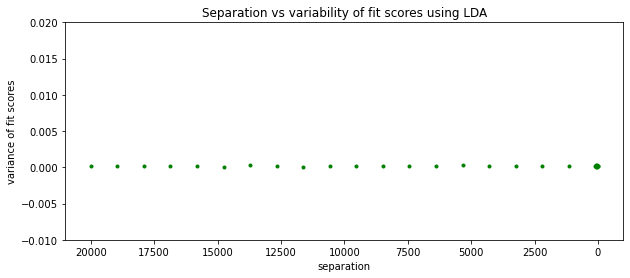

In [11]:
plt.figure(figsize=(10,4))
plt.plot(list(scoreTableLDA.columns),list(scoreTableLDA.var(axis=0)),'.g')
plt.xlabel('separation')
plt.ylabel('variance of fit scores')
plt.xlim(21000,-1000)
plt.ylim(-0.01,0.02)
plt.title('Separation vs variability of fit scores using LDA');

It can be seen that linear discriminant analysis does not suffer from the variability issue. It might attract someone's notice that the fit score of linear discriminant analysis is **both consistent and good**. However, it is the consistency we have focused on here. Why logistic regression settled for a poor fit at low separation values while LDA has a better fit - that is a question for some other time.

## 6. Conclusion:

Hence, as claimed in ***ISLR***, logistic regression indeed becomes unstable for well separated classes; the easier the situation gets the more erratically it behaves. LDA does not suffer from this problem. Hence, while using logistic regression in such scenarios, we have two approaches at our disposal - 

<ul>
    <li>scale the features. That will go to reduce the separation. Whether it will make the fit better as well as a general rule, needs further investigation. In this case one can verify that it actually does. Look at my <a href= "https://stackoverflow.com/questions/68150694/do-features-need-to-be-scaled-in-logistic-regression">stackoverflow question here</a>.</li>
    <li>use LDA.</li>
</ul>